In [5]:
import shap
import lime
import lime.lime_image
from skimage.segmentation import mark_boundaries
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import tensorflow as tf
import os
import cv2
import numpy as np
import tensorflow as tf
from keras import backend as K

In [6]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
model_path = os.path.join(parent_dir, 'models', "model_enhanced_unet_100.keras")

In [7]:
# Load the model
model = tf.keras.models.load_model(model_path)

In [8]:
# load test set data
X_test_path =  os.path.join(parent_dir, 'models', "X_test.npy")
X_test = np.load(X_test_path)

In [9]:
# load train set data
X_train_path =  os.path.join(parent_dir, 'models', "x_train_filtered_images.npy")
X_train = np.load(X_train_path)

In [13]:
print("Output type:", type(model.output[1]))
print("Output shape:", model.output[1].shape)

Output type: <class 'keras.src.backend.common.keras_tensor.KerasTensor'>
Output shape: (None, 7)


In [14]:
import cv2
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

# Load and preprocess the grayscale image
image_path = 'C:/users/wfaiz/Data_Science/PCB_Defect/data_full/Images/l_light_01_missing_hole_17_3_600.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
image = cv2.resize(image, (600, 600))

# Convert the grayscale image to pseudo-RGB by stacking the grayscale image into three channels
image_rgb = np.stack((image,)*3, axis=-1)

# Normalize the pseudo-RGB image
image_rgb = image_rgb / 255.0

# Expand dimensions to match the input shape expected by the model
image_rgb_expanded = np.expand_dims(image_rgb, axis=0)


In [17]:
def crop_image_to_patches(image, crop_size):
    patches = []
    for i in range(0, image.shape[0], crop_size[0]):
        for j in range(0, image.shape[1], crop_size[1]):
            patch = image[i:i + crop_size[0], j:j + crop_size[1]]
            patches.append(patch)
    return patches

image_path = 'C:/users/wfaiz/Data_Science/PCB_Defect/data_full/Images/l_light_01_missing_hole_17_3_600.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
image = cv2.resize(image, (600, 600))

patches = crop_image_to_patches(image, (100, 100))


In [18]:
patches_rgb = [np.stack((patch,)*3, axis=-1) / 255.0 for patch in patches]


In [26]:
def predict_fn(patches_rgb):
    patches_gray = np.mean(patches_rgb, axis=-1, keepdims=True)  # Convert back to grayscale
    print(patches_gray.shape)
    segmentation_predictions, classification_predictions = model.predict(patches_gray)
    print("Segmentation predictions shape:", segmentation_predictions.shape)
    print("Classification predictions shape:", classification_predictions.shape)
    # Depending on your requirements, you might want to return one of the outputs
    # For example, if you only need classification predictions for LIME:
    return classification_predictions


In [53]:
import os
import sys
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

def explain_instance_without_display(patch_rgb, predict_fn, top_labels=5, hide_color=None, num_samples=1000, num_features=5):
    # Redirect stdout to devnull to suppress output
    sys.stdout = open(os.devnull, 'w')
    # Create explainer object if not already created
    explainer = lime_image.LimeImageExplainer()
    # Get the explanation
    explanation = explainer.explain_instance(patch_rgb, predict_fn,
                                              top_labels=top_labels, hide_color=hide_color,
                                              num_samples=num_samples, num_features=num_features)
    # Restore stdout
    sys.stdout = sys.__stdout__
    return explanation

In [55]:
patch_explanations = []
for patch_rgb in patches_rgb:
    explanation = explain_instance_without_display(patch_rgb, predict_fn, 
                                                   top_labels=5, hide_color=0, 
                                                   num_samples=1000, num_features=5)
    patch_explanations.append(explanation)

100%|██████████| 1000/1000 [00:35<00:00, 27.81it/s]


In [56]:
# Extract the masks and combine them
masks = []
for explanation in patch_explanations:
    _, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                             positive_only=True,
                                             num_features=10,
                                             hide_rest=True)
    masks.append(mask)

In [57]:
# Function to reconstruct image from patches
def reconstruct_image_from_patches(patches, image_shape):
    reconstructed_image = np.zeros(image_shape, dtype=patches[0].dtype)
    patch_size = patches[0].shape[0:2]
    k = 0
    for i in range(0, image_shape[0], patch_size[0]):
        for j in range(0, image_shape[1], patch_size[1]):
            reconstructed_image[i:i + patch_size[0], j:j + patch_size[1]] = patches[k]
            k += 1
    return reconstructed_image

In [58]:
# Reconstruct the original image and the mask
reconstructed_image = reconstruct_image_from_patches(patches_rgb, image_rgb.shape)
reconstructed_mask = reconstruct_image_from_patches(masks, image_rgb.shape[:2])

# Overlay the mask on the image
overlay = mark_boundaries(reconstructed_image, reconstructed_mask)


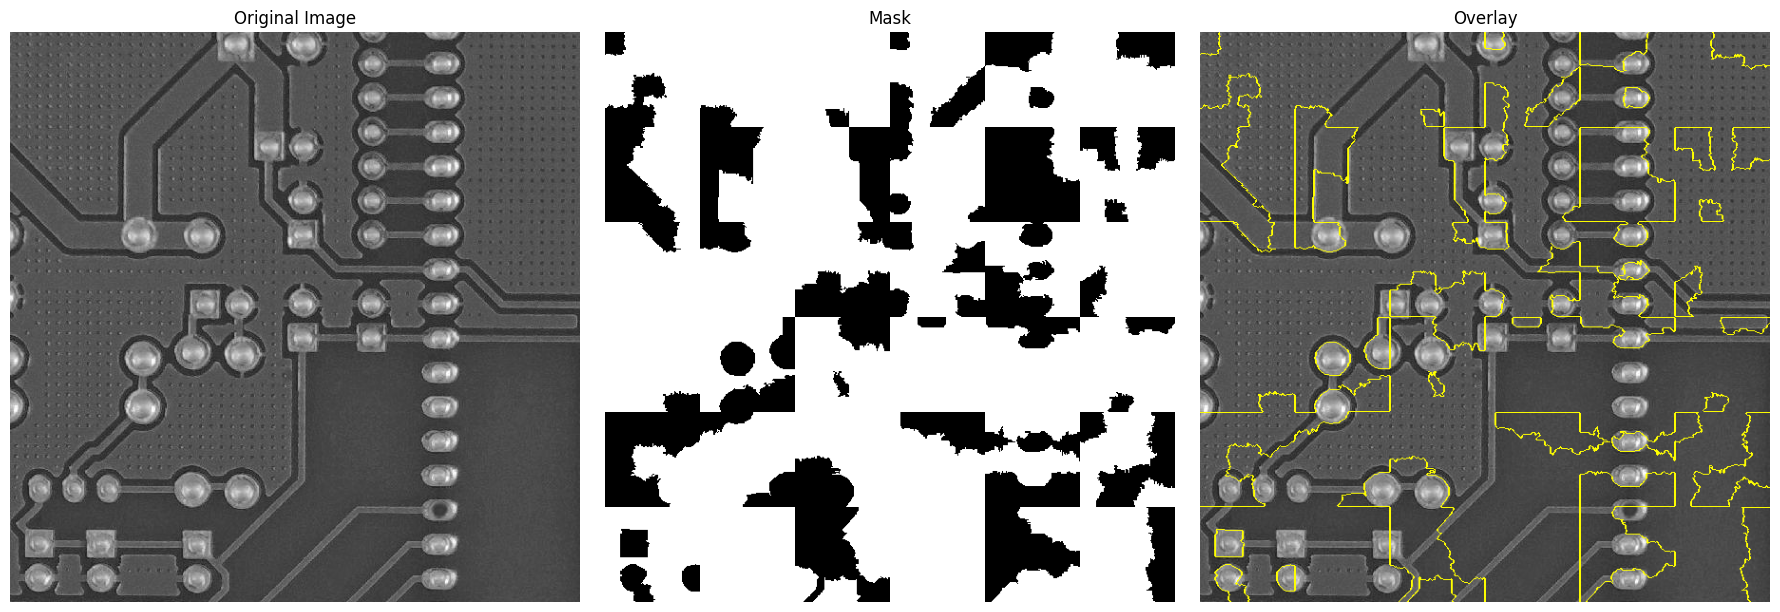

In [59]:
# Plot the original image, mask, and overlay
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(reconstructed_image)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(reconstructed_mask, cmap='gray')
ax[1].set_title('Mask')
ax[1].axis('off')

ax[2].imshow(overlay)
ax[2].set_title('Overlay')
ax[2].axis('off')

plt.tight_layout()
plt.show()